In [1]:
import matplotlib as mpl #画图用的库
import matplotlib.pyplot as plt
#下面这一句是为了可以在notebook中画图
%matplotlib inline
import numpy as np
import sklearn   #机器学习算法库
import pandas as pd #处理数据的库   
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras   #使用tensorflow中的keras
#import keras #单纯的使用keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, pd, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
sklearn 0.22
pandas 0.25.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist # 该数据集是黑白服装数据集
#拆分训练集和测试集
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
#将训练集拆分为训练集和验证集
#训练集共6万张图片，我们将前5000张作为验证集，后面所有的做训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train[0].dtype)
print(x_train[0]) # 是一个数据矩阵 28*28, 矩阵中的每一个数值都是uint8类型
print(y_train[0]) #这里的y值均为数字编码，非向量，所以后面定义模型损失函数为 sparse_categorical_crossentropy
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 

In [3]:
print(np.max(x_train), np.min(x_train))

255 0


In [4]:
#在图像分类领域我们提升准确率的手段 归一化：
# 1.对训练数据进行归一化 2. 批归一化

# x = (x - u)/std  u为均值，std为方差
from sklearn.preprocessing import StandardScaler #使用sklearn中的StandardScaler实现训练数据归一化

scaler = StandardScaler()

#fit_transform:得到方差、均值、最大最小值然后数据进行归一化操作
#https://blog.csdn.net/youhuakongzhi/article/details/90519801
#x_train：先转为float32用于做除法，x_train本身为三维矩阵[None,28,28]，因为fit_transform要求二维数据所以需要转换为[None, 784]，再转回三维矩阵
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
#是因为在trainData的时候，已经使用fit()得到了整体的指标（均值，方差等）并被保存起来了后面验证集测试集可以使用，所以在测试集上直接transform()，使用之前的指标，
#如果在测试集上再进行fit()，由于两次的数据不一样，导致得到不同的指标，会使预测发生偏差，因为模型是针对之前的数据fit()出来
#的标准来训练的，而现在的数据是新的标准，会导致预测的不准确
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [5]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


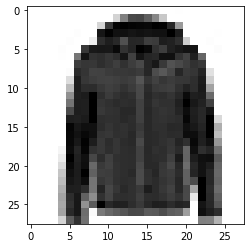

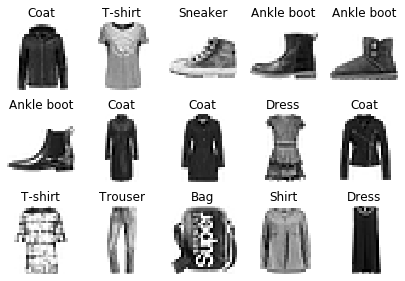

In [6]:
#展示一下数据集中的图片

###展示单张图片
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary") #cmap:将标准化标量映射为颜色, binary代表白底黑字
    plt.show()
show_single_image(x_train[0])

###展示图片组
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6)) #.figure 在plt中绘制一张图片
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1) # 创建单个子图
            plt.imshow(x_data[index], cmap="binary", interpolation='nearest')
            plt.axis('off') #取消坐标系
            plt.title(class_names[y_data[index]]) #标题
    plt.show()
    
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

In [7]:
#tf.keras.models.Sequential()

#模型的两种写法
#1.方法1
'''
model = keras.models.Sequential()
#model = keras.Sequential()
#Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡，输入是28*28的图像
model.add(keras.layers.Flatten(input_shape=[28, 28]))
#Dense层为全连接层，单元数设置为300，激活函数为 relu
model.add(keras.layers.Dense(300, activation="relu"))
#全连接层2
model.add(keras.layers.Dense(100, activation="relu"))
#全连接层3
model.add(keras.layers.Dense(10, activation="softmax"))
'''
#激活函数定义：
#relu: y=max(0,x)
#softmax:将向量变成概率分布. X = [x1, x2, x3]  ==转换成==>  y = [e^x1/sum, e^x2/sum, e^x3/sum], sum=e^x1 + e^x2 + e^x3

#2.方法2
'''
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
'''
model = keras.models.Sequential()  
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    #model.add(keras.layers.Dense(100,activation="relu"))
    #model.add(keras.layers.BatchNormalization())#这里批归一化是放在激活函数之后
    """#批归一化放在激活函数之前的一种实现,可行
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    """
    model.add(keras.layers.Dense(100,activation="selu"))# 激活函数selu自带数据归一化功能，在一定程度上也能缓解梯度消失问题

#这里演示只添加一层添加Dropout,放在此处表示给前面一层做Dropout
#AlphaDropout优点: 
#1.均值和方差不变：普通的dropout在dropout之后可能激活值分布就发生变化，但是alphadropout并不会
#2.归一化性质不变：因为均值和方差不变所以归一化性质也就不变，那么可以结合bn、selu来使用，因为他不会导致分布发生变化
model.add(keras.layers.AlphaDropout(rate=0.5))#rete表示去掉的单元数比例，一般设置为0.5,此时子网络数目最大


#model.add(keras.layers.Dropout(rate=0.5))＃一般不使用Dropout
model.add(keras.layers.Dense(10,activation="softmax"))


#计算目标函数
# reason for sparse: y->index. y->one_hot->[]
#如果你的 targets 是 one-hot 编码，用 categorical_crossentropy
#　　one-hot 编码：[0, 0, 1], [1, 0, 0], [0, 1, 0]
#如果你的 tagets 是 数字编码 ，用 sparse_categorical_crossentropy
#　　数字编码：2, 0, 1
#这里前面有print过y的值，为数字，所以使用 sparse_categorical_crossentropy
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam", #optimizer="sgd", 优化算法一般来说我们无脑用adam即可
             metrics=["accuracy"])

In [8]:
#查看model有多少层
model.layers

In [9]:
#查看模型的架构信息
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [10]:
#Tensorflow中的callback用于模型训练过程中的一些监听操作，常用的callback类型如下三类：
#Tensorboard 可视化Tensorboard
#earlystopping 当loss函数不能再优化时停止训练,这样可以截取到最优的模型参数
#ModelCheckpoint 每次epoch之后就保存模型

#当前目录下新建一个callbacks文件夹并在里面创建一个h5模型文件
import shutil
logdir='./callbacks_dnn'

if os.path.exists(logdir):
    shutil.rmtree(logdir) #先强制删除该文件夹，后面再新建
else:
    os.mkdir(logdir)
        
output_model_file=os.path.join(logdir,"fashion_mnist_model.h5")#在logdir中创建一个模型文件.h5

#定义一个callbacks数组
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),#这里第二个参数表示仅保存最好的那个模型
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]


#fit用于训练
history=model.fit(x_train_scaled, y_train, epochs=10, #epochs用于遍历训练集次数
                  validation_data=(x_valid_scaled,y_valid),#加入验证集，每隔一段时间就对验证集进行验证
                  callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 184us/sample - loss: 0.7189 - accuracy: 0.7583 - val_loss: 0.5480 - val_accuracy: 0.8312
Epoch 2/10
55000/55000 [==============================] - 9s 166us/sample - loss: 0.5778 - accuracy: 0.8115 - val_loss: 0.5328 - val_accuracy: 0.8206
Epoch 3/10
55000/55000 [==============================] - 8s 148us/sample - loss: 0.5323 - accuracy: 0.8260 - val_loss: 0.5671 - val_accuracy: 0.8200
Epoch 4/10
55000/55000 [==============================] - 9s 157us/sample - loss: 0.5280 - accuracy: 0.8250 - val_loss: 0.5515 - val_accuracy: 0.8328
Epoch 5/10
55000/55000 [==============================] - 8s 147us/sample - loss: 0.5114 - accuracy: 0.8314 - val_loss: 0.5122 - val_accuracy: 0.8414
Epoch 6/10
55000/55000 [==============================] - 8s 150us/sample - loss: 0.5451 - accuracy: 0.8185 - val_loss: 0.4825 - val_accuracy: 0.8558
Epoch 7/10
55000/55000 [==========================

In [11]:
type(history)

tensorflow.python.keras.callbacks.History

In [12]:
#history记录的是所有训练过程中的一些指标数据
history.history

{'loss': [0.7188644389586015,
  0.5778338608221574,
  0.5322800043539567,
  0.5280355058626696,
  0.5114058590758931,
  0.5450711552836678,
  0.5575689913684672,
  0.47437829135981474,
  0.44880029145587574,
  0.5388841896577314],
 'accuracy': [0.7582727,
  0.81145453,
  0.82603633,
  0.8249636,
  0.8313636,
  0.81854546,
  0.8064,
  0.8421091,
  0.8495273,
  0.8200909],
 'val_loss': [0.5479798924207687,
  0.5328224311351776,
  0.5671166725158692,
  0.5514796880722046,
  0.5121886026620864,
  0.48252104544639585,
  0.4766990184783936,
  0.45672841762304306,
  0.44951888127326967,
  0.8549088745117187],
 'val_accuracy': [0.8312,
  0.8206,
  0.82,
  0.8328,
  0.8414,
  0.8558,
  0.8486,
  0.8582,
  0.858,
  0.7048]}

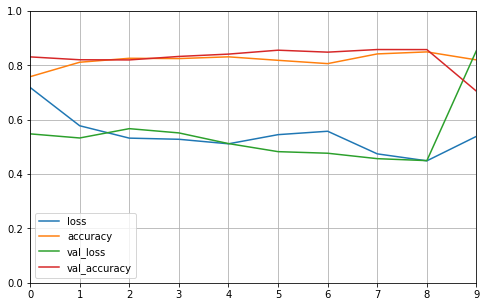

In [13]:
#将上面history中的数据指标用一张图来表示

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5)) #设置图的大小
    plt.grid(True) #显示网格
    plt.gca().set_ylim(0,1) #设置y轴范围
    plt.show()
plot_learning_curves(history)

#刚开始曲线很平滑的原因：
#1.参数众多，训练不充分
#2.梯度消失->链式法则->复合函数ｆ(g(x))
# 批归一化缓解梯度消失现象

In [14]:
#测试集上进行测试评估一下
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8799518074989319, 0.696]